***
Цели и задачи проекта. 

Отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска. Для достижения данной цели поставлены и решены задачи оценки качества данных об учащихся, выявления и устранения выбросов, устранения коррелирующих и малоинформативных показателей, анализа распределения ответов среди разных категорий учащихся.
***

In [ ]:
from scipy.stats import ttest_ind
from itertools import combinations
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
students = pd.read_csv('stud_math.csv')
display(students.head(3))
print('Длина df: ', len(students))

pd.set_option('display.max_columns', 40)  # показывать больше колонок

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0


Длина df:  395


***
Исходя из условия задачи, нам необходимо оценить влияние различных параметров на итоговую величину баллов (score).
В связи с этим, принято решение сразу удалить из датасета записи, не содержащие информацию о количестве набранных баллов. 
***

In [4]:
students.dropna(subset=['score'], inplace=True)
print('Новая длина df: ', len(students))

Новая длина df:  389


***
Посмотрим и удалим столбцы, в которых перевес любого из признаков слишком существенный.
***

In [5]:
huge_value_share = [col for col in students.columns if students[col].value_counts(
    dropna=False, normalize=True).values[0] > 0.88]
print(huge_value_share, ' - имеют существенное влияние одного из факторов.')

students.drop(huge_value_share, axis=1, inplace=True)  # очищаем датасет

['school', 'higher']  - имеют существенное влияние одного из факторов.


In [6]:
many_null_cols = [col for col in students.columns if students[col].isnull().sum() / students.shape[0] > 0.095]
print(many_null_cols, ' - имеют более 9.5% пустых значений.')

['Pstatus', 'famsup', 'paid']  - имеют более 9.5% пустых значений.


In [7]:
print(
    f'В датасете {students.isnull().any().sum()} столбцов содержат пустые значения.')

В датасете 25 столбцов содержат пустые значения.


In [8]:
# Проверка наличия столбцов с неизменным значением
one_value_cols = [
    col for col in students.columns if students[col].nunique() <= 1]
print(f'В датасете {len(one_value_cols)} столбцов с неизменными значениями.')

В датасете 0 столбцов с неизменными значениями.


***
Вывод:

Таким образом, большинство столбцов содержат в себе не менее 1 пустого значения. Наибольшая доля из которых - в 'Pstatus', 'famsup', 'paid', что некритично. Так же в датасете отсутствуют столбцы с единственным и неизменным значением, которые нужно было бы удалить как неинформативные.

Перейдём к классификации показателей на количественные, номинативные, порядковые и, отдельно, бинарные.
***

In [9]:
variable = []  # количественные
nominat = []  # номинативные
ordinal = []  # порядковые
binary = []  # бинарные

for column in students.columns:
    # Перечень всех вариантов ответов в столбце
    variables = students[column].unique()
    if len(variables) <= 3:
        datatype = 'binary'  # бинарный, если с учётом NaN их 2-3
        binary.append(column)
    # в остальных случаях для строковых данных - номинативный
    elif students[column].dtype == 'object':
        datatype = 'nominat'
        nominat.append(column)
    elif len(variables) <= 7:  # порядковый, если вариантов ответов не больше 7
        datatype = 'ordinal'
        ordinal.append(column)
    else:
        datatype = 'variable'  # в остальных случаях - количественный
        variable.append(column)

print('Бинарные переменные: ', len(binary), binary)
print('Порядковые переменные: ', len(ordinal), ordinal)
print('Номинативные переменные: ', len(nominat), nominat)
print('Количественные переменные: ', len(variable), variable)

Бинарные переменные:  11 ['sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'internet', 'romantic']
Порядковые переменные:  10 ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'studytime, granular', 'famrel', 'freetime', 'goout', 'health']
Номинативные переменные:  4 ['Mjob', 'Fjob', 'reason', 'guardian']
Количественные переменные:  3 ['age', 'absences', 'score']


***
Таким образом, большинство переменных имеют либо бинарный (2 значения + NaN), либо порядковый числовой признак (градация до 6 вариантов числовых ответов + NaN). Так же присутствуют 4 количественных и 3 номинативных переменных. 

Для начала рассмотрим количественные переменные.
***

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

Text(0.5, 1.0, 'Количество баллов')

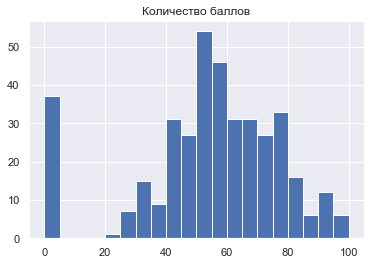

In [11]:
"""
1. Количество баллов
"""

sns.set()
display(students.score.describe())
students.score.hist(bins=20)
plt.title('Количество баллов')

***
'score' - наша предсказываемая величина. 

Нетипичных значений (меньше 0 или больше 100) не обнаружено. Пустые значения были очищены ещё на первой стадии.

Больше 30 учеников получили 0 баллов. Этот кластер значений, возможно, обусловлен техническими ошибками подсчёта баллов, либо какими-либо штрафными санкциями, что по своей сути не связано с интересующими нас факторами и может повлиять на корректность результатов исследования. Минимально значимой величиной, исходя из визульного анализа, является 20 баллов.

Принято решение удалить записи, содержащие 0 в значении 'score'.
***

In [12]:
students.drop(students[students.score == 0].index, inplace=True)
print('Длина df после очистки: ', len(students))

Длина df после очистки:  352


count    352.000000
mean      57.755682
std       16.200928
min       20.000000
25%       45.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

Text(0.5, 1.0, 'Количество баллов')

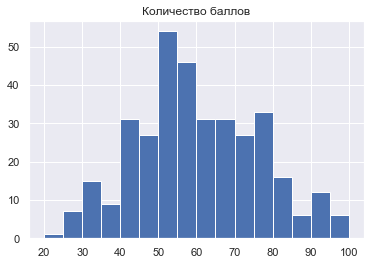

In [13]:
sns.set()
display(students.score.describe())
students.score.hist(bins=16)
plt.title('Количество баллов')

***
Распределение обновлённых данных визуально кажется (более-менее) нормальным с медианой 55 баллов.
***

In [14]:
"""
2. Возраст
"""

students.age.value_counts(dropna=False)

16    96
17    90
15    76
18    69
19    16
20     3
22     1
21     1
Name: age, dtype: int64

***
Пропусков значений возраста нет. Несмотря на то, что разброс данных (от 15 до 22 лет) соответствует условию задачи, записей студентов в возрасте 20+ всего 5 из всей выборки. Воизбежание неверной интерпретации выводов, эти записи будут исключены из анализа.
***

In [15]:
students.drop(students[students.age >= 20].index, inplace=True)
print('Длина df после очистки: ', len(students))

Длина df после очистки:  347


count    347.000000
mean      16.576369
std        1.166396
min       15.000000
25%       16.000000
50%       17.000000
75%       17.000000
max       19.000000
Name: age, dtype: float64

Text(0.5, 1.0, 'Возраст')

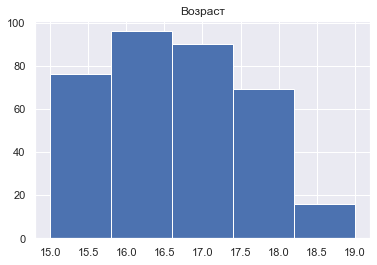

In [16]:
display(students.age.describe())
plt.hist(students['age'], bins=5)
plt.title('Возраст')

***
Теперь данные распределены относительно равномерно. Посмотрим на распределение оценок по возрасту.
***

Text(0, 0.5, 'Score')

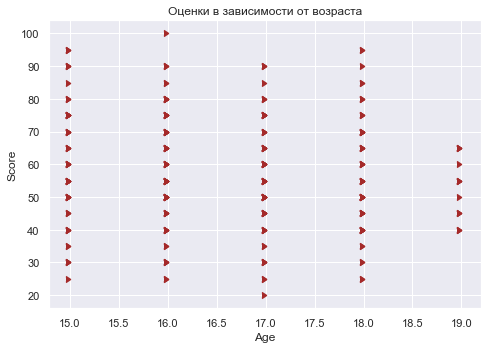

In [17]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.scatter(x=students['age'], y=students['score'], marker=5, color='brown')
axes.set_title('Оценки в зависимости от возраста')
axes.set_xlabel('Age')
axes.set_ylabel('Score')

In [18]:
for k in students.age.value_counts().keys():
    print(k, students[students.age == k].score.median())

16 57.5
17 55.0
15 60.0
18 55.0
19 55.0


***
Хоть визуально могло показаться, что среди 19-ти летних оценки ниже, медиана у них равна группе 17-ти и 18-ти летних, и общей по датасету = 55.
***

count    337.000000
mean       7.513353
std       22.244327
min        0.000000
25%        2.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

Text(0.5, 1.0, 'Количество пропущенных занятий')

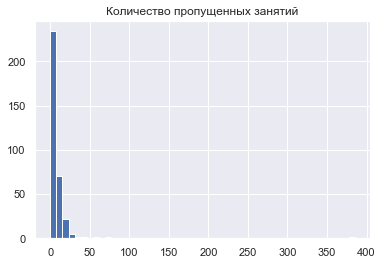

In [19]:
"""
3. Количество пропущенных занятий
"""

display(students.absences.describe())
students.absences.hist(bins=50)
plt.title('Количество пропущенных занятий')

***
Здесь видно, что большинство учеников вообще не пропускало занятий, а медиана - всего 4 пропуска. 

Однако, есть, как минимум 1 выброс (максимальное значение) 385, что противоречит здравому смыслу. 
Среднее значение из-за выбросов заметно выше, чем медиана (7.5 vs 4).

Рассмотрим подробнее.
***

In [20]:
# С помощью межквартильного размаха оценим границы выбросов
q1 = students.absences.quantile(q=0.25, interpolation='midpoint')
q3 = students.absences.quantile(q=0.75, interpolation='midpoint')
iqr = q3 - q1
k = 3  # Коэффициент , определяющий границы выбросов. Стандартно - это 1.5, но я возьму более обширные границы
print('Q1: {} \nQ3: {} \nIQR: {}\nk*IQR: {}'.format(q1, q3, iqr, k*iqr))

# Далее оценим, какие записи можно считать выбросами
out = []
for row in students.absences:
    if row-q3 > iqr*k or row-q1 < iqr*-k:
        out.append(row)
print(f'Число выбросов: {len(out)}, от {min(out)} до {max(out)}')

# И очистим датафрейм от выбросов в столбце absences
students.drop(students[students.absences.isin(out)].index, inplace=True)
print('Длина df после очистки: ', len(students))

Q1: 2.0 
Q3: 8.0 
IQR: 6.0
k*IQR: 18.0
Число выбросов: 8, от 28.0 до 385.0
Длина df после очистки:  339


count    329.000000
mean       5.550152
std        5.662086
min        0.000000
25%        2.000000
50%        4.000000
75%        8.000000
max       26.000000
Name: absences, dtype: float64

Text(0.5, 1.0, 'Количество пропущенных занятий')

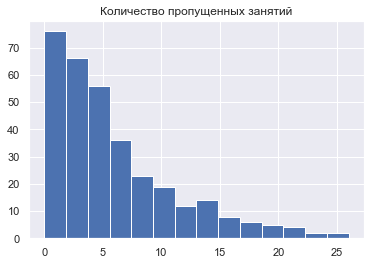

In [22]:
# Повторно посмотрим на очищенный показатель absences
display(students.absences.describe())
plt.hist(students['absences'], bins=14)
plt.title('Количество пропущенных занятий')

***
После корректировки, распределение стало более наглядным. Очевидно равномерное снижение числа пропущенных занятий среди студентов. Есть, правда, небольшой скачок среди тех, кто пропускал 12 занятий. Среднее значение стало ближе к медиане (5.6 vs 4).

Посмотрим распределение оценок по этому параметру.
***

Text(0, 0.5, 'absences')

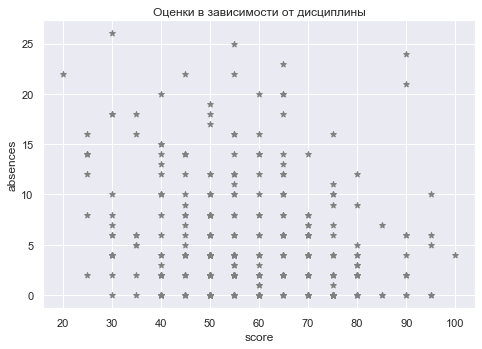

In [23]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.scatter(x=students['score'], y=students['absences'],
             marker='*', color='grey')
axes.set_title('Оценки в зависимости от дисциплины')
axes.set_xlabel('score')
axes.set_ylabel('absences')

***
Однозначной зависимости оценок от посещаемости нет. Соотношение ведёт себя хаотично.
***

In [24]:
students[variable].corr()

,age,absences,score
age,1.000000,0.214597,-0.120940
absences,0.214597,1.000000,-0.207903
score,-0.120940,-0.207903,1.000000


***
Количественные переменные между собой не коррелируют.


Далее перейдём к рассмотрению порядковых переменных.
***


Показатель: Medu


4.0    0.359882
2.0    0.250737
3.0    0.238938
1.0    0.135693
0.0    0.008850
NaN    0.005900
Name: Medu, dtype: float64

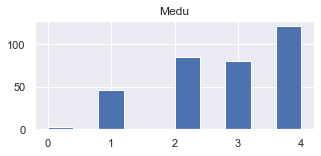


Показатель: Fedu


2.0     0.265487
3.0     0.250737
4.0     0.230088
1.0     0.185841
NaN     0.058997
0.0     0.005900
40.0    0.002950
Name: Fedu, dtype: float64

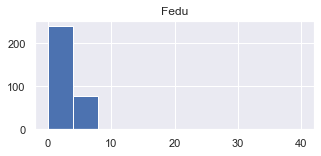


Показатель: traveltime


1.0    0.619469
2.0    0.241888
NaN    0.067847
3.0    0.050147
4.0    0.020649
Name: traveltime, dtype: float64

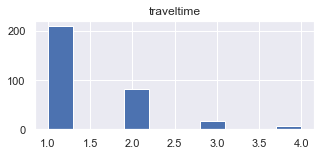


Показатель: studytime


2.0    0.495575
1.0    0.250737
3.0    0.162242
4.0    0.070796
NaN    0.020649
Name: studytime, dtype: float64

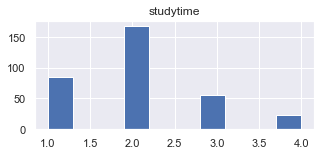


Показатель: failures


0.0    0.790560
1.0    0.103245
NaN    0.056047
2.0    0.026549
3.0    0.023599
Name: failures, dtype: float64

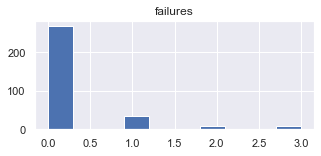


Показатель: studytime, granular


-6.0     0.495575
-3.0     0.250737
-9.0     0.162242
-12.0    0.070796
 NaN     0.020649
Name: studytime, granular, dtype: float64

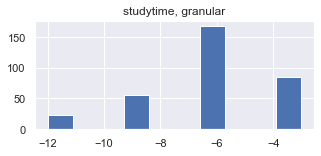


Показатель: famrel


 4.0    0.466077
 5.0    0.241888
 3.0    0.165192
 NaN    0.067847
 2.0    0.038348
 1.0    0.017699
-1.0    0.002950
Name: famrel, dtype: float64

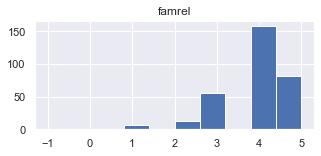


Показатель: freetime


3.0    0.380531
4.0    0.292035
2.0    0.174041
5.0    0.094395
1.0    0.041298
NaN    0.017699
Name: freetime, dtype: float64

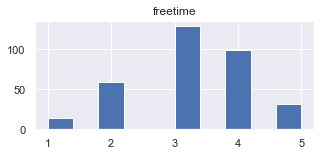


Показатель: goout


3.0    0.330383
2.0    0.268437
4.0    0.209440
5.0    0.123894
1.0    0.050147
NaN    0.017699
Name: goout, dtype: float64

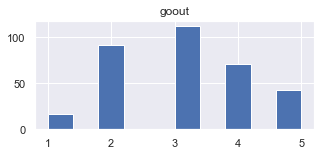


Показатель: health


5.0    0.351032
3.0    0.227139
4.0    0.150442
1.0    0.126844
2.0    0.106195
NaN    0.038348
Name: health, dtype: float64

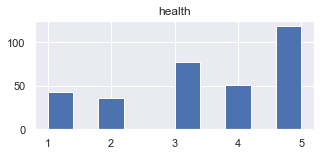

In [25]:
"""
1. Рассмотрим процентное распределение вариантов ответов в порядковых переменных
"""


def ordin_prop(factor):
    print(f'\nПоказатель: {factor}')
    proportion = students[factor].value_counts(dropna=False, normalize=True)
    # Интересно, как округлить нормализованные значения в value_counts?
    display(proportion)
    figure = plt.subplots(figsize=(5, 2))  # Добавим компактную гистограмму
    plt.hist(students[factor])
    plt.title(factor)
    plt.show()


# Применим функцию для каждой порядковой переменной
for factor in ordinal:
    ordin_prop(factor)

***
Учитывая описание специфики полей датасета, а так же процентное распределение вариантов ответов, делаем вывод, что переменные 'Fedu' и 'famrel' содержат выбросы (40 и -1 соответственно). Необходимо очистить датасет от этих полей и записей.
***

In [26]:
students.drop(students[(students.Fedu == 40) | (
    students.famrel == -1)].index, inplace=True)

***
Также в описании полей отсутствуют сведения о переменной "studytime, granular", значения которой к тому же отрицательны и неинтерпретируемы. Проверим взаимосвязь значений этого параметра со "studytime".
***

In [27]:
students[['studytime', 'studytime, granular']].corr()

,studytime,"studytime, granular"
studytime,1.0,-1.0
"studytime, granular",-1.0,1.0


***
Очевидно, что параметр "studytime, granular" для анализа неинтересен. Удаляем из датасета.
***

In [28]:
students.drop(['studytime, granular'], axis=1, inplace=True)

# обновление списка полей порядковых переменных
ordinal.remove('studytime, granular')

print('Длина df после очистки: ', len(students))

Длина df после очистки:  337



Показатель: Medu


4.0    0.362018
2.0    0.246291
3.0    0.240356
1.0    0.136499
0.0    0.008902
NaN    0.005935
Name: Medu, dtype: float64

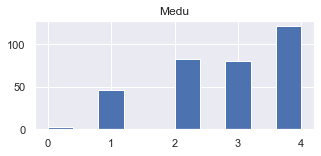


Показатель: Fedu


2.0    0.264095
3.0    0.252226
4.0    0.231454
1.0    0.186944
NaN    0.059347
0.0    0.005935
Name: Fedu, dtype: float64

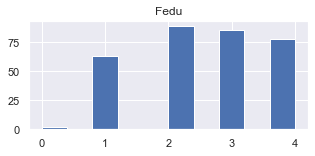


Показатель: traveltime


1.0    0.620178
2.0    0.243323
NaN    0.068249
3.0    0.047478
4.0    0.020772
Name: traveltime, dtype: float64

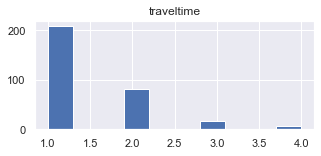


Показатель: studytime


2.0    0.498516
1.0    0.249258
3.0    0.160237
4.0    0.071217
NaN    0.020772
Name: studytime, dtype: float64

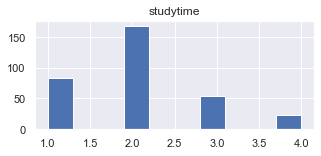


Показатель: failures


0.0    0.792285
1.0    0.103858
NaN    0.056380
2.0    0.023739
3.0    0.023739
Name: failures, dtype: float64

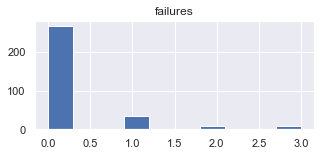


Показатель: famrel


4.0    0.468843
5.0    0.240356
3.0    0.166172
NaN    0.068249
2.0    0.038576
1.0    0.017804
Name: famrel, dtype: float64

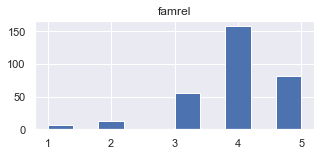


Показатель: freetime


3.0    0.382789
4.0    0.293769
2.0    0.169139
5.0    0.094955
1.0    0.041543
NaN    0.017804
Name: freetime, dtype: float64

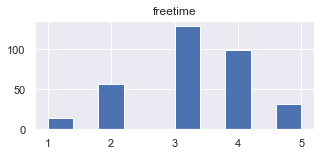


Показатель: goout


3.0    0.332344
2.0    0.264095
4.0    0.210682
5.0    0.124629
1.0    0.050445
NaN    0.017804
Name: goout, dtype: float64

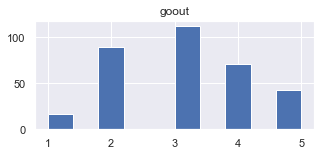


Показатель: health


5.0    0.350148
3.0    0.228487
4.0    0.148368
1.0    0.127596
2.0    0.106825
NaN    0.038576
Name: health, dtype: float64

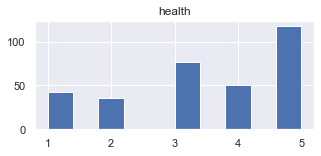

In [29]:
# Посмотрим на нормированное распределение ответов повторно, после очистки.
for factor in ordinal:
    ordin_prop(factor)

***
Выводы:
1. В большинстве случаев образование матери - высшее, в то время как образование отца распределено достаточно равномерно.
2. Время в пути до школы чаще всего < 2 часов. Достаточно много пропусков в данных.
3. Половина учеников тратит на учёбу вне школы 2-5 часов.
4. Большинство не имеют внеучебных неудач, 10% имеют 1. Достаточно много пропусков в данных.
5. Семейные отношения чаще всего хорошие. Достаточно много пропусков в данных.
6. Свободное время распределено нормально.
7. Может показаться, что далеко не все студенты проводят свободное время с друзьями. Однако, это, скорее всего, оценочные, эмоциональные суждения. Например, 5 минут в планке и 5 минут на обед - это в любом случае 5 минут, но воспринимаются они совершенно по-разному.
8. Тех, кто чувствует себя хорошо, и плохо, либо очень плохо - относительно поровну.
***

In [30]:
# убираем из рассмотрения неинформативные порядковые переменные
notinform = ['traveltime', 'failures', 'famrel', 'goout']
ordinal = [x for x in ordinal if x not in notinform]

***
Проведём корреляционный анализ порядковых числовых переменных.
***

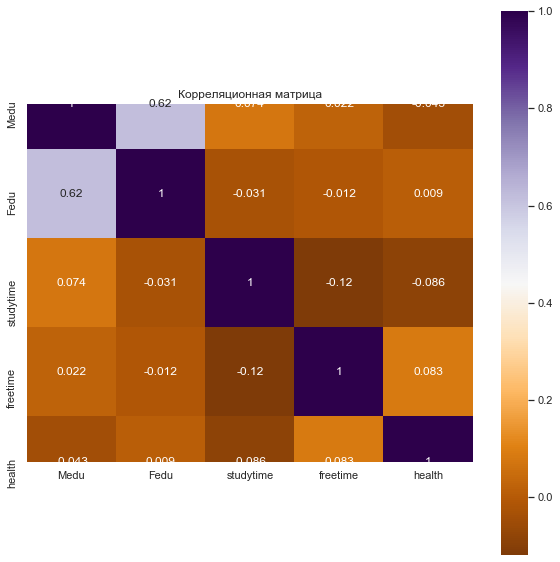

In [31]:
correlation = students[ordinal].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='PuOr')
plt.title('Корреляционная матрица')
plt.show()

***
Fedu и Medu между собой коррелируют (k > 0.4). 

Оставляем из них Medu, т.к. у Fedu доля пустых значений выше, чем доля вещественного значения "0" (5.9% vs 0.6%).
***

In [39]:
ordinal.remove('Fedu')
ordinal

['Medu', 'studytime', 'freetime', 'health']

***
Перейдём к рассмотрению номинативных переменных.
***

In [33]:
for col in nominat:
    display(students[col].value_counts(dropna=False))

other       110
services     83
teacher      50
at_home      48
health       29
NaN          17
Name: Mjob, dtype: int64

other       169
services     82
NaN          32
teacher      25
health       15
at_home      14
Name: Fjob, dtype: int64

course        115
reputation     92
home           84
other          31
NaN            15
Name: reason, dtype: int64

mother    217
father     77
NaN        26
other      17
Name: guardian, dtype: int64

***
Работы родителей у большинства - other, что естественно. 

Причины выбора школы распределены почти равномерно. Но больше - из-за программы.

Опекун в 2/3 случаев - мать.
***

In [34]:
# Посмотрим, как распределены оценки, в зависимости от вариантов ответов среди номинативных переменных
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.boxplot(x=column, y='score',
                data=students.loc[students.loc[:, column].isin(
                    students.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

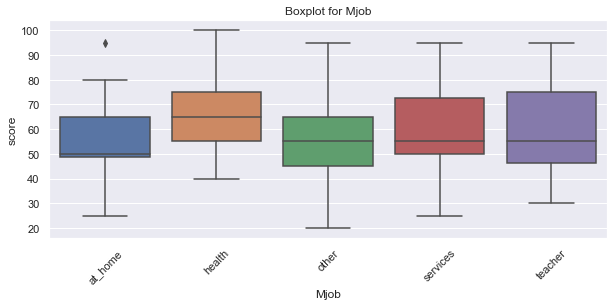

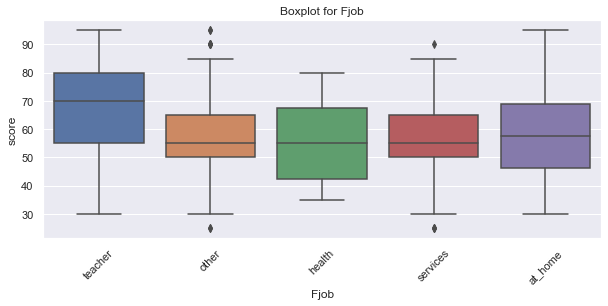

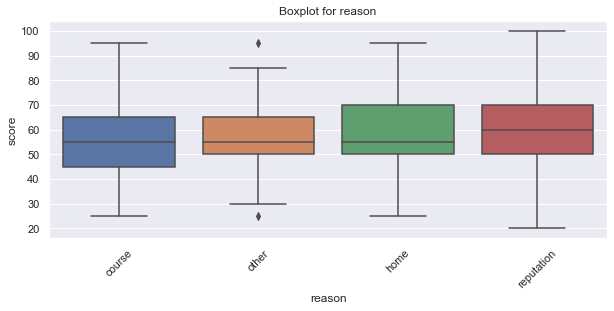

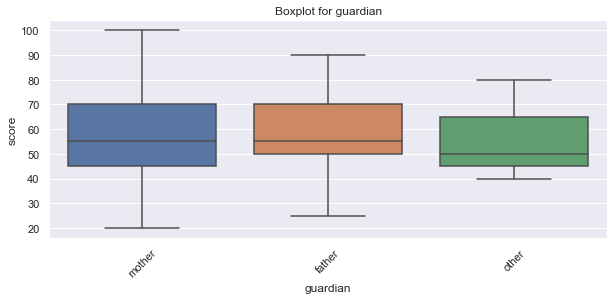

In [35]:
for factor in nominat:
    get_boxplot(factor)

In [36]:
# Проверим статистическую значимость на уровне 10%
def get_stat_dif(column):
    cols = students.loc[:, column].value_counts().index[:5]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(students.loc[students.loc[:, column] == comb[0], 'score'],
                     students.loc[students.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.1/len(combinations_all):
            print('Найдены статистически значимые различия для колонки', column)
            break

In [37]:
for factor in nominat:
    get_stat_dif(factor)

Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки Fjob


In [38]:
# Оставляем только эти значимые параметры
nominat = ['Mjob', 'Fjob']

['Mjob', 'Fjob']

***
Перейдём к рассмотрению бинарных переменных.
***

In [40]:
for factor in binary:
    print(f'Показатель: {factor}')
    print(students[factor].value_counts(dropna=False, normalize=True), '\n')

Показатель: sex
F    0.513353
M    0.486647
Name: sex, dtype: float64 

Показатель: address
U      0.753709
R      0.207715
NaN    0.038576
Name: address, dtype: float64 

Показатель: famsize
GT3    0.640950
LE3    0.290801
NaN    0.068249
Name: famsize, dtype: float64 

Показатель: Pstatus
T      0.801187
NaN    0.109792
A      0.089021
Name: Pstatus, dtype: float64 

Показатель: schoolsup
no     0.839763
yes    0.136499
NaN    0.023739
Name: schoolsup, dtype: float64 

Показатель: famsup
yes    0.557864
no     0.341246
NaN    0.100890
Name: famsup, dtype: float64 

Показатель: paid
no     0.480712
yes    0.412463
NaN    0.106825
Name: paid, dtype: float64 

Показатель: activities
yes    0.495549
no     0.468843
NaN    0.035608
Name: activities, dtype: float64 

Показатель: nursery
yes    0.777448
no     0.186944
NaN    0.035608
Name: nursery, dtype: float64 

Показатель: internet
yes    0.777448
no     0.136499
NaN    0.086053
Name: internet, dtype: float64 

Показатель: romantic
no 

***
Отберём показатели, в которых присутствуют варианты yes/no.
***

In [41]:
bin_bool = []  # список для yes/no
bin_other = []  # список для остальных

for p in binary:
    if 'yes' in set(students[p]):
        bin_bool.append(p)
    else:
        bin_other.append(p)
print('Содержат логический признак: ', bin_bool)
print('Не содержат логический признак: ', bin_other)

Содержат логический признак:  ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'internet', 'romantic']
Не содержат логический признак:  ['sex', 'address', 'famsize', 'Pstatus']


***
Преобразуем данные с логическим признаком на 1 и 0.
***

In [42]:
def bool_code(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return None


for factor in bin_bool:
    students[factor] = students[factor].apply(bool_code)

display(students[bin_bool].head(3))

,schoolsup,famsup,paid,activities,nursery,internet,romantic
0,1.0,0.0,0.0,0.0,1.0,NaN,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,NaN,0.0,1.0,1.0,NaN


***
Посмотрим на матрицу корреляций данных признаков.
***

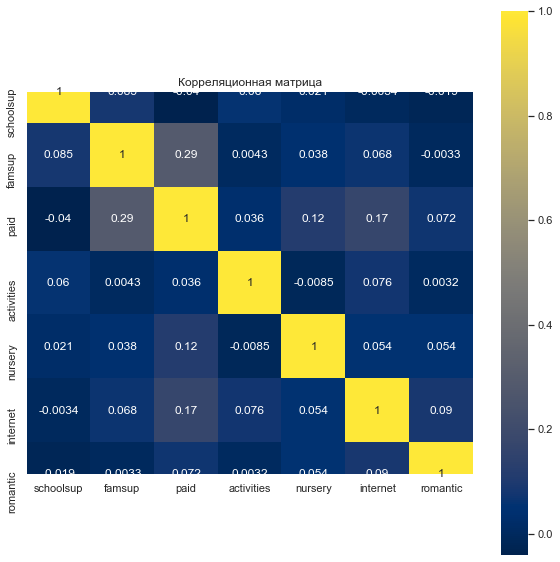

In [43]:
correlation = students[bin_bool].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cividis')
plt.title('Корреляционная матрица')
plt.show()

***
Явной корреляции бинарных признаков не обнаружено. Максимальный k=0.29 (< 0.4) у 'famsup' и 'paid'. По своему смыслу эти параметры близки: "Семейная образовательная поддержка" и "Дополнительные платные занятия по математике".

Так как "paid" присутствует в ТОП-3 параметров с наибольшим числом пустых значений, удалим его.
***

In [44]:
binary.remove('paid')
bin_bool.remove('paid')

***
Посмотрим, как распределена выручка по бинарным переменным.
***

In [45]:
def binar_rev(factor):
    #fig, ax = plt.subplots(figsize = (6, 4))
    sns.catplot(x=factor, y='score', data=students,
                height=3, aspect=2, palette="husl")
    plt.title('Score for ' + factor)
    plt.show()

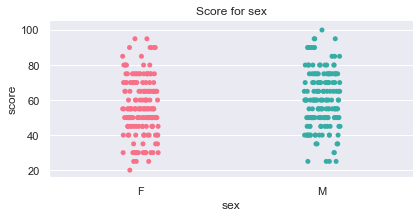

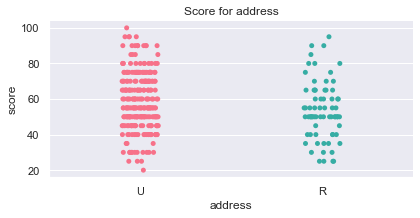

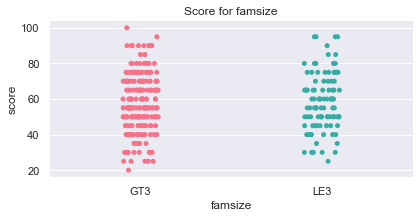

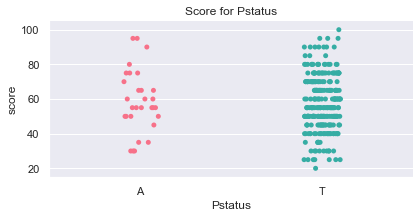

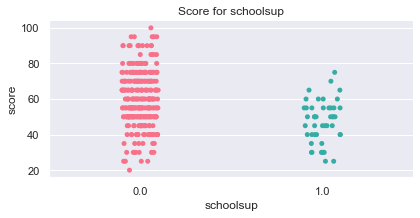

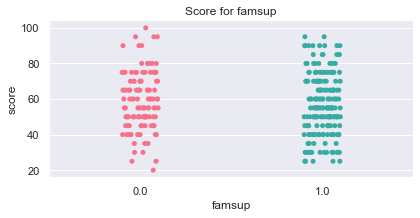

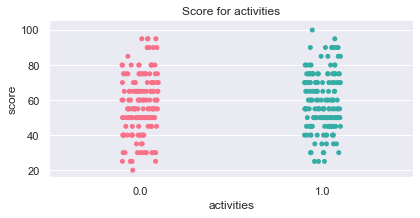

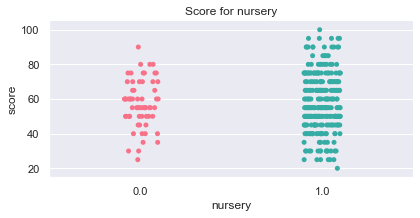

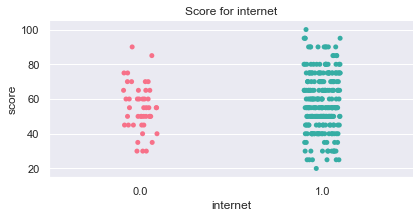

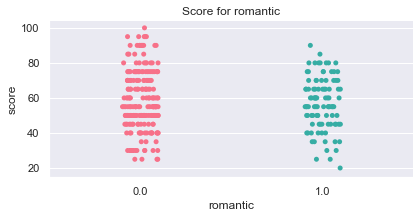

In [46]:
for factor in binary:
    binar_rev(factor)

***
Забавно, что среди тех студентов, кто пользовался школьной дополнительной образовательной поддержкой (schoolsup = 1), результаты оказались существенно ниже, чем у другой группы. При этом, семейная образовательная поддержка (famsup = 1) очевидной пользы не принесла.

Выводы:
1. Лучше с экзаменом справились:
    1. Мальчики
    2. Живущие в городе
    3. Без доп. образов. поддержки
    4. С доп. внеучебными занятиями
    5. Не состоящие в отношениях


2. Неинформативные показатели:
    1. Размер семьи
    2. Статус совместного жилья родителей
    3. Семейная образовательная поддержка
    4. Посещение дет.сада
    5. Наличие интернета
***

In [47]:
# Проверка предположений
for factor in binary:
    get_stat_dif(factor)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки schoolsup


In [49]:
# Уберём неинформативные параметры из набора бинарных переменных
not_inf = ['famsize', 'Pstatus', 'famsup', 'activities', 'nursery', 'internet']
binary = [x for x in binary if x not in not_inf]
binary

['sex', 'address', 'schoolsup', 'romantic']

***
Посмотрим, какие в итоге параметры остались в датасете как влияющие на результат.
***

In [66]:
final_list = variable + nominat + ordinal + binary
final_df = students[final_list]
final_df.head()

,age,absences,Mjob,Fjob,Medu,studytime,freetime,health,sex,address,schoolsup,romantic,score
0,18,6.0,at_home,teacher,4.0,2.0,3.0,3.0,F,U,1.0,0.0,30.0
1,17,4.0,at_home,other,1.0,2.0,3.0,3.0,F,U,0.0,0.0,30.0
2,15,10.0,at_home,other,1.0,2.0,3.0,3.0,F,U,1.0,NaN,50.0
3,15,2.0,health,NaN,4.0,3.0,2.0,5.0,F,U,0.0,1.0,75.0
4,16,4.0,other,other,3.0,2.0,3.0,5.0,F,U,0.0,0.0,50.0


In [69]:
c = 0
for index, row in final_df.iterrows():
    if row.isnull().sum() > 0:
        c += 1
print('Число строк с хотя бы 1 пустым значением: {}. Их доля от общей длины df ({}): {}'.format(
    c, len(final_df), round(c/len(final_df), 2)))

Число строк с хотя бы 1 пустым значением: 109. Их доля от общей длины df (337): 0.32


***
В датасете остались пустые значения. На данном этапе не могу сказать, насколько это будет критично. Если бы мы очистили датасет от всех записей, содержащих хотя бы 1 пустое значение, то из 337 строк осталось бы 228, и качество выборки заметно бы ухудшилось. 
***

***
Анализ данных показал, что полученные результаты экзаменов по математике во многом зависели от самых разных факторов, таких, как работа матери, количество свободного времени или даже наличия романтических отношений. Для более полного понимания взаимосвязей разных параметров необходимо провести факторный и кластерный анализ данных, а так же провести кроссчекинг факторов. Например, хоть посещаемость и не оказывает прямого влияния на сумму баллов, я сомневаюсь, что это случайный показатель. Возможно, в сопоставлении с другими порядковыми или номинативными переменными удастся найти взаимосвязь. То же касается и поло-возрастных групп. 

В целом, выборка достаточно качественная.
***